## Описание проекта "Прогнозирование оттока клиентов банка"

Клиенты это основа успеха любого бизнеса, в том числе и банковской деятельности. Поэтомы банки заинтересованытв создании условий для предотвращения оттока клиентов.

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

В проекте мы будем строить модель, которая спрогнозирует уйдёт клиент из банка в ближайшее время или нет.
Используем исторические данные о поведении клиентов и расторжении договоров с банком.

Построим модель с предельно большим значением F1-меры. Нижняя граница метрики F1 - 0.59. 

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

**Цель: Построить модель с предельно большим значением меры F1**

### План

Шаг 1. Изучение общей информации данных.

Шаг 2. Предобработка данных.

Шаг 3. Исследование баланса данных.

Шаг 4. Построение модели без учета дисбаланса данных. Выводы.

Шаг 5. Улучшение качества модели, учитывая дисбаланс классов. Обучаем разные модели и найдим лучшую. Выводы.

Шаг 6. Проводим финальное тестирование.


In [4]:
import pandas as pd #loading the necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

## Изучение общей информации

In [5]:
df = pd.read_csv('Churn.csv') #/datasets/Churn.csv 
display(df.head(10))
df.info()
print(f'процент положительных ответов:{round(df.Exited.mean()*100)} \n')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
процент положительных ответов:20 



Мы имеем данные с таблицей, состоящей из 14 столбцов и 10000 наблюдений (строчек).

**Признаки**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

Типы данных соответствуют описанию данных.

Столбец ответов бинарный. Процент положительных ответов составляет около 20%. Явный дисбаланс классов.

Пропуски присутствуют только в столбце 'Tenure' - количество лет, в течении которых человек является клиентом банка.

Таблица имеет категориальные и количественные признаки.


## Предобработка данных

Приведем название столбцов в нижний регистр с нижним подчеркиванием.

In [6]:
for name in df.columns:
    df.rename(columns = {name: '_'.join(re.findall('[A-Z][^A-Z]*', name)).lower()}, inplace=True)
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим таблицу на наличие повторов. Проверяем по клиентскому номеру.

In [7]:
df.duplicated('customer_id').sum()

0

Удалим те столбцы, которые не нужны для построения моделей: 
- row_number - столбец повторяет индексацию, никакой информационной нагрузки не несет
- customer_id, surname — персональные данные не нужны для построения моделей

In [8]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis = 1)
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


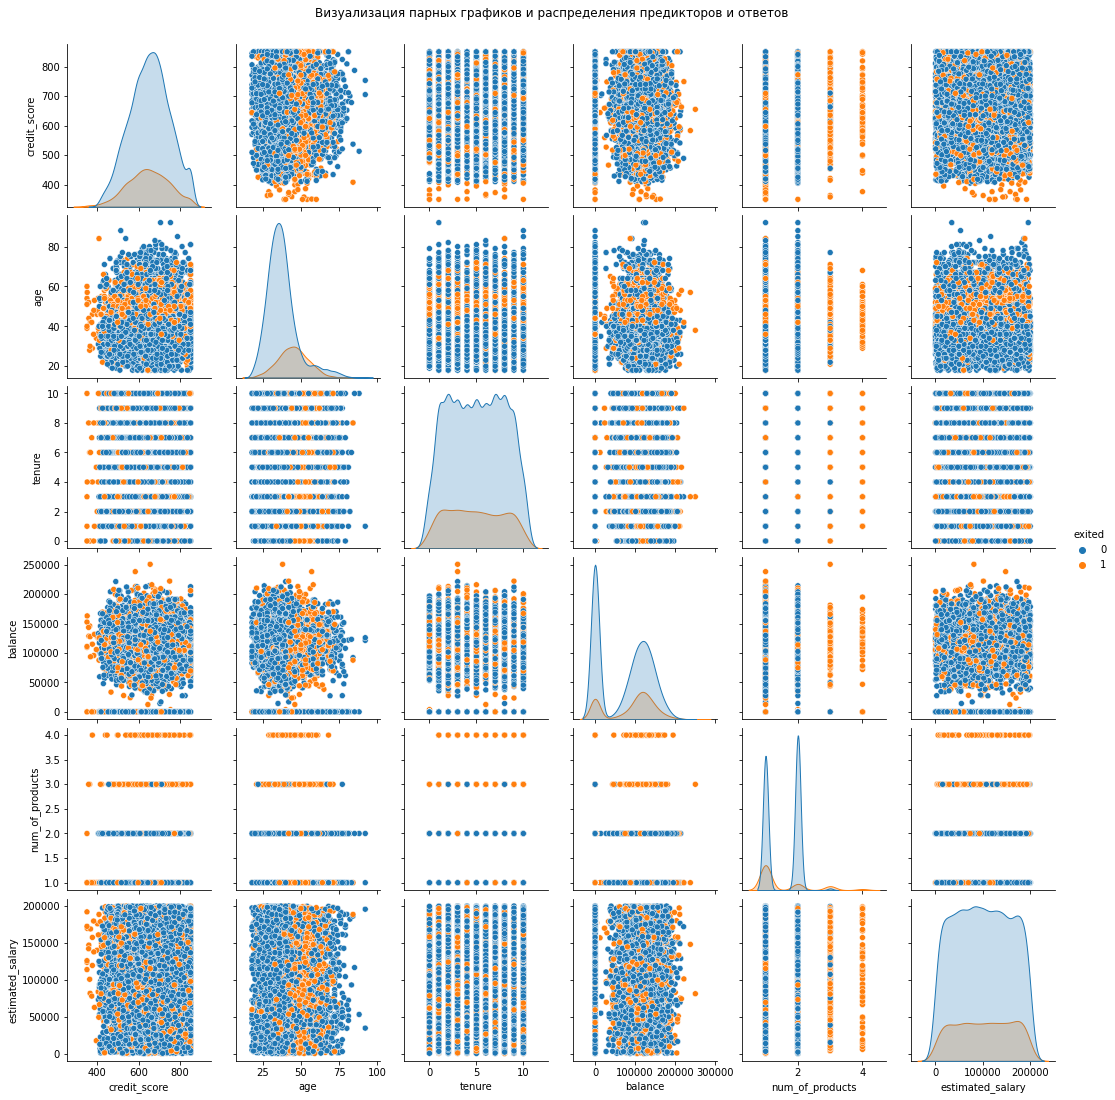

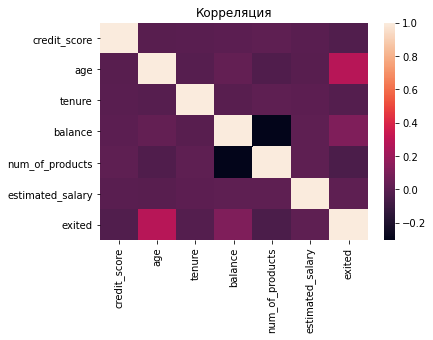

In [9]:
columns = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary', 'exited']
sns.pairplot(df[columns], hue = 'exited')
plt.suptitle("Визуализация парных графиков и распределения предикторов и ответов", y =1.02) # y= some height>1
plt.show()
sns.heatmap(df[columns].corr())
plt.title('Корреляция')
plt.show()

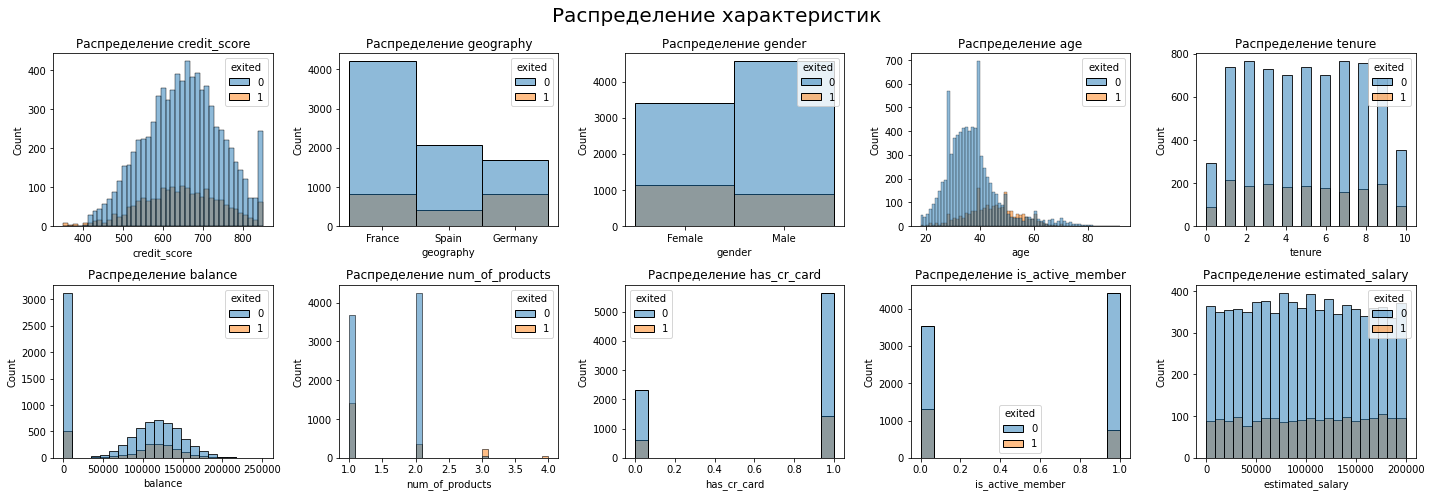

In [10]:
features_name = df.columns
fig, ax = plt.subplots(2,5, figsize = (20,7))
fig.suptitle('Распределение характеристик', fontsize = 20)
for i in range(2):
    for j in range(5):
        ax[i,j] = sns.histplot(data = df, x = features_name[j+i*5], ax = ax[i,j], hue = 'exited')
        ax[i,j].set_title(f'Распределение {features_name[j+i*5]}')
plt.tight_layout()

Из парных графиков мы можем описать некоторые наблюдения:
- перестают быть клиентами банка в основном люди среднего возраста (40-60лет) - скученность оранжевых точек в центре скатерплота.
- люди, которые испоьзуют более двух продуктов банка скорее всего перестанут быть клиентами банка.
- люди, имеющий кредитный рейтинг меньше 400, перестают быть клиентами банка.
- мультиколлинеарных признаков нет.
- распределение значений признака estimated_salary, tenure вызывает вопросы. создается впечатление синтетического набора данных.

Обработаем пропуски в столбце 'tenure'.

Пропусков в столбце "tenure": 9.09%


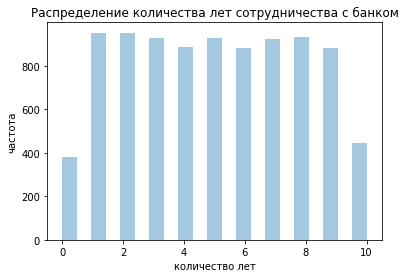

In [11]:
print(f'Пропусков в столбце "tenure": {df.tenure.isna().mean()*100}%')
sns.distplot(df.tenure, kde = False)
plt.title('Распределение количества лет сотрудничества с банком')
plt.xlabel('количество лет')
plt.ylabel('частота')
plt.show()

Рассмотрим 3 варианта заполнения пропусков в данных. Затем выберем лучшую модель.
- заполнение пропущенных значений минимальным значением - нулем
- заполнение пропусков медианным значением
- удаление строк, содержащих пропущенные значения
- удаление столбца Tenure

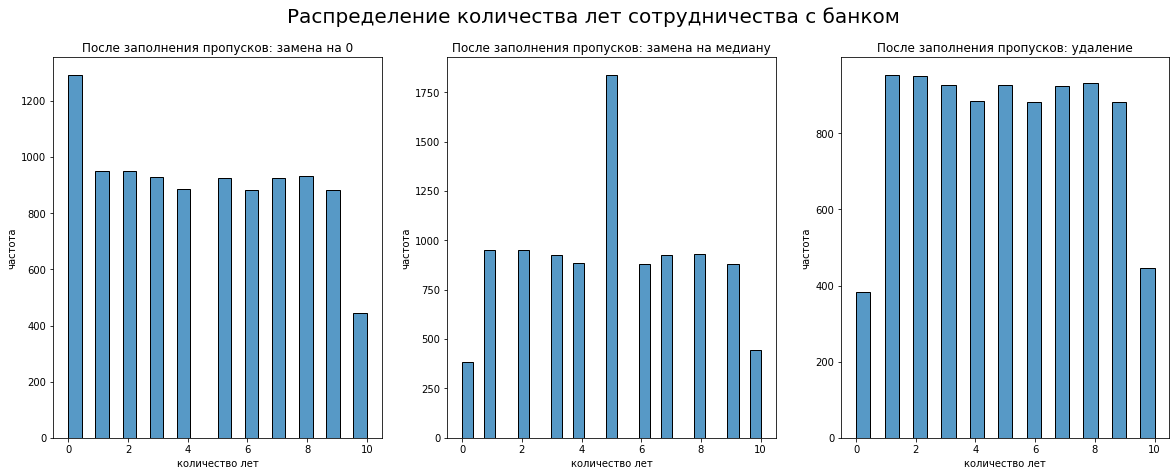

In [12]:
df_nul = df.copy()
df_nul['tenure'] = df_nul.tenure.fillna(0)

df_median= df.copy()
df_median['tenure'] = df_median.tenure.fillna(df_median.tenure.median())

df_del = df.copy()
df_del = df_del.dropna(axis = 0)

df_drop = df.copy()
df_drop = df_drop.drop(['tenure'], axis = 1)

df_list = [df_nul, df_median, df_del]
list_name = ['замена на 0', 'замена на медиану','удаление']
fig, ax = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Распределение количества лет сотрудничества с банком', fontsize = 20)
for i in range(len(df_list)):
    ax[i] = sns.histplot(df_list[i].tenure, ax = ax[i])
    ax[i].set_title(f'После заполнения пропусков: {list_name[i]}')
    ax[i].set_xlabel('количество лет')
    ax[i].set_ylabel('частота')
plt.show()

В двух первых вариантах распределение величины меняется, поэтому считаю, что нам это не подходит.

В третьем варианте мы уменьшаем нашу выборку на 9%, что может привести к недостатку данных.

Учитывая не очень хорошее распределение этой величины(не нормальное, а равномерное - что говорит о синтетичности данных), а также низкую корреляцию с целевым признаком, будем использовать 4 вариант, а именно удалим весь столбец 'tenure'. T.e. далее будем использовать датасет df_drop.

NB! для интереса подставляла все остальные датафреймы. Действительно, лучший результат получался на датасете df_drop.

## Подготовка данных

Создадим датафрейм, созданный по методу прямого кодирования с защитой от дамми-ловушки.

Разделим данные на целевой столбец target и матрицу признаков features.

Разобъем данные следующим образом:

- features_train, target_train - обучающая выборка 60%
- features_valid, target_valid - валидационная выборка 20%
- features_test, target_test - тестовая выборка 20%

При разбивке используем параметр stratify, который выполняет разбиение, так что доля значений в созданной выборке будет такой же, как доля значений, предоставленных параметру stratify. В нашем случае указываем stratify = target

In [13]:
df_drop = pd.get_dummies(df_drop, drop_first = True) # ohe-coding
features = df_drop.drop('exited', axis = 1)
target = df_drop['exited']
features_train_valid, features_test, target_train_valid, target_test = train_test_split(features, target, test_size = .2, 
                                                                                        random_state = 12345, stratify = target) 
features_train, features_valid, target_train, target_valid = train_test_split(features_train_valid, target_train_valid, test_size = .25,
                                                                              random_state = 12345, stratify = target_train_valid) 
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 10) (6000,)
(2000, 10) (2000,)
(2000, 10) (2000,)


## Исследование баланса данных

Посмотрим какой существует дисбаланс классов. Поскольку при разделении данных мы использовали `stratify`, баланс классов для подвыборок (train, valid, test) должен сохранятся.

In [14]:
df['exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Соотношение классов 1:4. Изучим модели без исправление баланса.

## Построение моделей без учета баланса классов

Будем использовать следующие модели:

- Логистическая регрессия
- Случайный лес
- Решающее дерево

In [15]:
def metrics(name, model, x_test, y_test): 
    """function that summarize all scores of the model in the dictionary. 
    Input parameters: name of the model, model and features_valid that equal to features_valid by default
    and equal to features_valid_scaled for Logistic Regression"""
    predicted = model.predict(x_test)
    accuracy = accuracy_score(y_test, predicted)
    recall = recall_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    f1 = f1_score(y_test, predicted)
    probabilities = model.predict_proba(x_test)
    probabilities_one = probabilities[:, 1]
    auc_roc = roc_auc_score(y_test, probabilities_one)
    print('Параметры модели:')
    pprint(model.get_params())
    dict_scores = {name:[accuracy, recall, precision, f1, auc_roc]}
    scores = pd.DataFrame(dict_scores).T
    scores.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'auc_roc']
    display(scores)
    return dict_scores

### Decision Tree Classifier

Поскольку далее в проекте (для учета дисбаланса класса) будем искать еще модели случайного леса на разных тренировочных данных, вынесем построение-обучение модели в отдельную функцию.  

In [16]:
def DT_model(x_train, y_train, class_weight):
    """building and training the best model Decision Tree Classifier
    with a choice of hyperparameters by GridSearchCV"""
    params = {'max_depth': range(1, 10), 'min_samples_leaf': range(1,5), 'min_samples_split': range(1,5)}
    model = DecisionTreeClassifier(random_state = 12345, class_weight = class_weight)
    grid = GridSearchCV(model, params, scoring = 'f1')
    grid.fit(x_train, y_train)
    return grid.best_estimator_

In [17]:
%%time
best_model_DT = DT_model(features_train, target_train, None)
dict_DT = metrics('Decision Tree Classifier',best_model_DT, features_valid, target_valid)

Параметры модели:
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12345,
 'splitter': 'best'}


,accuracy,recall,precision,f1_score,auc_roc
Decision Tree Classifier,0.856,0.511057,0.700337,0.590909,0.827298


CPU times: total: 9.3 s
Wall time: 9.38 s


### Random Forest Classifier

In [18]:
def RF_model(x_train, y_train, class_weight):
    params = {'n_estimators': range(50, 200,5), 'min_samples_leaf': range(1,5)}
    model = RandomForestClassifier(random_state = 12345, class_weight = class_weight)
    grid = GridSearchCV(model, params, scoring = 'f1')
    grid.fit(x_train, y_train)
    return grid.best_estimator_

In [19]:
%%time
best_model_RF = RF_model(features_train, target_train, None)
dict_RF = metrics('Random Forest Classifier', best_model_RF, features_valid, target_valid)

Параметры модели:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 95,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Random Forest Classifier,0.8585,0.444717,0.760504,0.56124,0.85809


CPU times: total: 5min 26s
Wall time: 5min 42s


### Logistic Regression Classifier

Для логистической регрессии применим масштабирование признаков.

In [20]:
def scaler(x, features_train = features_train):
    scaler = MinMaxScaler()
    scaler.fit(features_train)
    return scaler.transform(x)

features_train_scaled = scaler(features_train)
features_valid_scaled = scaler(features_valid)
features_test_scaled = scaler(features_test)

In [21]:
def LR_model(x_train, y_train, class_weight):
    params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    model = LogisticRegression(random_state = 12345, class_weight = class_weight)
    grid = GridSearchCV(model, params, cv = 10, scoring = 'f1')
    grid.fit(x_train, y_train)
    return grid.best_estimator_

In [22]:
%%time
best_model_LR = LR_model(features_train_scaled, target_train, None)
dict_LR = metrics('Logistic Regression Classifier', best_model_LR, features_valid_scaled, target_valid)

Параметры модели:
{'C': 10.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667


CPU times: total: 6.64 s
Wall time: 7.09 s


Объединим результаты по трем моделям.

In [23]:
dict_scores = {**dict_DT,**dict_RF, **dict_LR}
table_scores = pd.DataFrame(dict_scores).T
table_scores.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'auc_roc']
table_scores

,accuracy,recall,precision,f1_score,auc_roc
Decision Tree Classifier,0.8560,0.511057,0.700337,0.590909,0.827298
Random Forest Classifier,0.8585,0.444717,0.760504,0.561240,0.858090
Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667


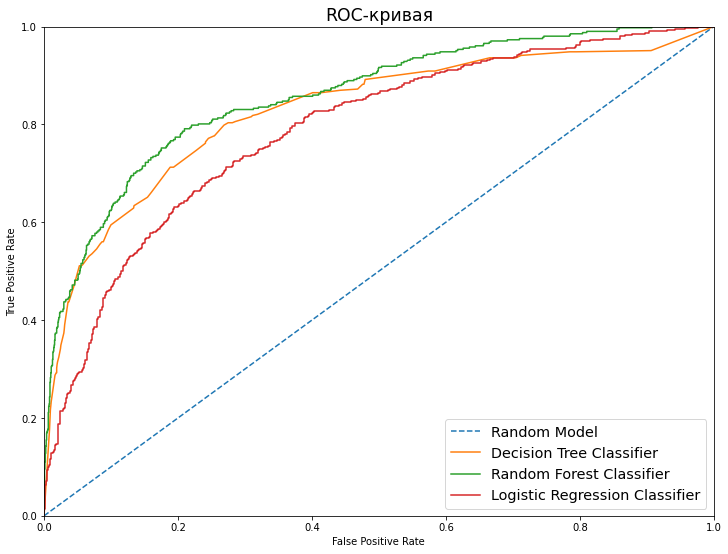

In [24]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

def roc(name, model, x_test, y_test):
    """ROC-curve fitting function"""
    probabilities_valid = model.predict_proba(x_test)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)
    plt.plot(fpr, tpr, label= name)
    
roc('Decision Tree Classifier', best_model_DT, features_valid, target_valid)
roc('Random Forest Classifier', best_model_RF, features_valid, target_valid)
roc('Logistic Regression Classifier', best_model_LR, features_valid_scaled, target_valid)
    
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-кривая", fontsize = 'xx-large')
plt.show()

<a id = 'data_preparation'></a>
<div style = 'border: solid green 4px; padding: 20px'>
    
**ВЫВОДЫ**
    
По результатам исследования моделей без учёта дисбаланса классов наибольшее значение F1-меры показала модель Decision Tree. 

AUC-ROC лучшая на Random Forest.

В данных сущестует дисбаланс классов в отношении 1:4.

Возможно он влияет на качество изучаемых моделей. Все модели имеют полноту(recall) ниже, чем точность(percision), из-за перекоса данных, что влияет на F-меру.

## Борьба с дисбалансом данных

Рассмотрим матрицы ошибок наших моделей.

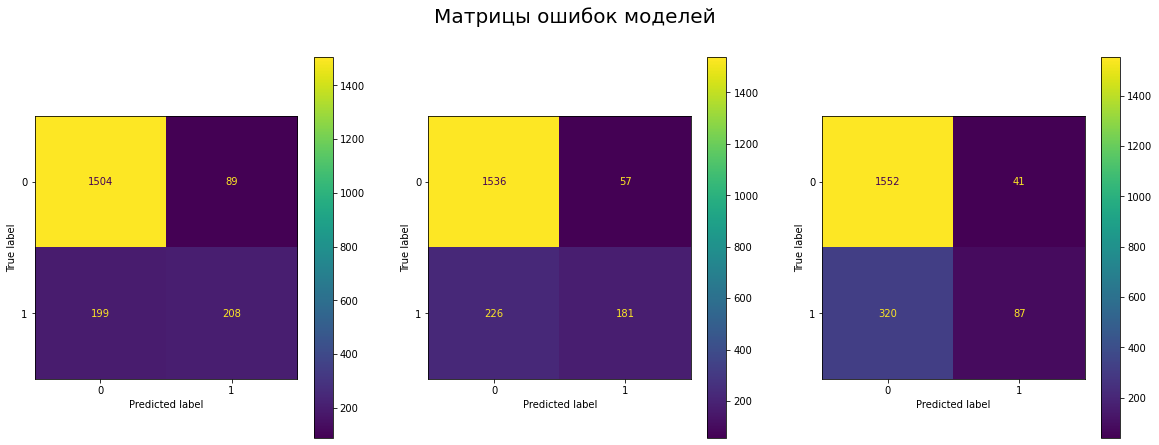

In [25]:
fig, ax = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Матрицы ошибок моделей', fontsize = 20)
ax[0]=ConfusionMatrixDisplay.from_estimator(best_model_DT, features_valid, target_valid, ax = ax[0])
ax[1]=ConfusionMatrixDisplay.from_estimator(best_model_RF, features_valid, target_valid, ax = ax[1])
ax[2]=ConfusionMatrixDisplay.from_estimator(best_model_LR, features_valid_scaled, target_valid, ax = ax[2])
plt.show()

При проверке матрицы ошибок большинство предсказанных результатов являются истинно отрицательными и ложно отрицательными. Этот результат имеет сильное смещение при прогнозировании, поскольку данных класса '0' гораздо больше, чем класса '1'.
Таким образом, мы не можем ожидать достойного результата при прогнозировании значений класса меньшинства с несбалансированным набором данных.

Для борьбы с дисбалансом выполним сравнение моделей:

- С взвешенными классами
- С уменьшенной выборкой
- С увеличенной выборкой

### Взвешенные классы

In [26]:
print('Decision Tree Classifier balanced')
best_model_DT_balanced = DT_model(features_train, target_train, 'balanced')
dict_DT_balanced = metrics('Decision Tree Classifier balanced',best_model_DT_balanced, features_valid, target_valid)
print('\n')

print('Random Forest Classifier balanced')
best_model_RF_balanced = RF_model(features_train, target_train, 'balanced')
dict_RF_balanced = metrics('Random Forest Classifier balanced',best_model_RF_balanced, features_valid, target_valid)
print('\n')

print('Logistic Regression Classifier balanced')
best_model_LR_balanced = LR_model(features_train_scaled, target_train, 'balanced')
dict_LR_balanced = metrics('Logistic Regression Classifier balanced', best_model_LR_balanced, features_valid_scaled, target_valid)

Decision Tree Classifier balanced
Параметры модели:
{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12345,
 'splitter': 'best'}


,accuracy,recall,precision,f1_score,auc_roc
Decision Tree Classifier balanced,0.758,0.781327,0.446003,0.567857,0.821116




Random Forest Classifier balanced
Параметры модели:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Random Forest Classifier balanced,0.846,0.624079,0.621027,0.622549,0.864092




Logistic Regression Classifier balanced
Параметры модели:
{'C': 0.1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Logistic Regression Classifier balanced,0.717,0.724816,0.393858,0.510381,0.790893


In [27]:
dict_scores_balanced = {**dict_DT_balanced,**dict_RF_balanced, **dict_LR_balanced}
table_scores_balanced = pd.DataFrame(dict_scores_balanced).T
table_scores_balanced.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'auc_roc']
pd.concat([table_scores, table_scores_balanced]).reset_index().sort_values(by = 'index')

,index,accuracy,recall,precision,f1_score,auc_roc
0,Decision Tree Classifier,0.8560,0.511057,0.700337,0.590909,0.827298
3,Decision Tree Classifier balanced,0.7580,0.781327,0.446003,0.567857,0.821116
2,Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667
5,Logistic Regression Classifier balanced,0.7170,0.724816,0.393858,0.510381,0.790893
1,Random Forest Classifier,0.8585,0.444717,0.760504,0.561240,0.858090
4,Random Forest Classifier balanced,0.8460,0.624079,0.621027,0.622549,0.864092


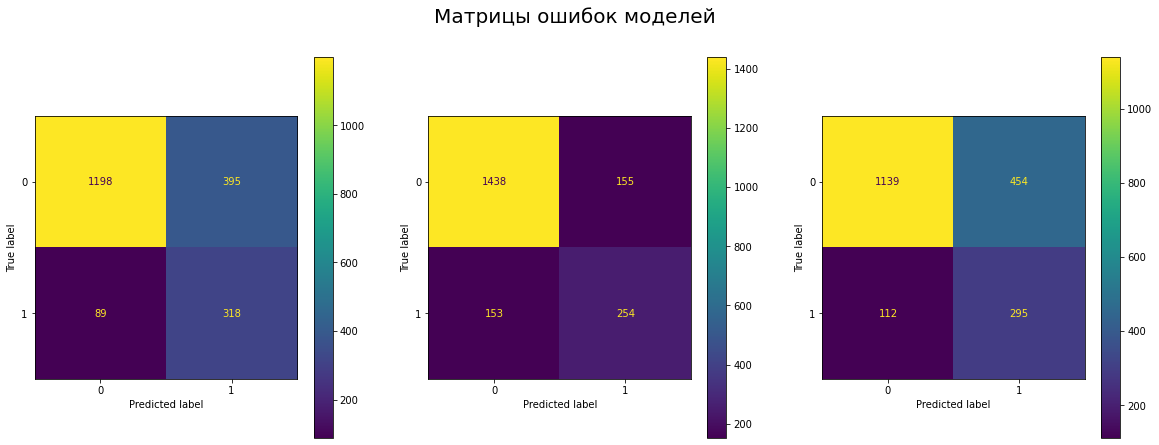

In [28]:
fig, ax = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Матрицы ошибок моделей', fontsize = 20)
ax[0]=ConfusionMatrixDisplay.from_estimator(best_model_DT_balanced, features_valid, target_valid, ax = ax[0])
ax[1]=ConfusionMatrixDisplay.from_estimator(best_model_RF_balanced, features_valid, target_valid, ax = ax[1])
ax[2]=ConfusionMatrixDisplay.from_estimator(best_model_LR_balanced, features_valid_scaled, target_valid, ax = ax[2])
plt.show()

F-мера упала у Decision Tree, произошло перераспределение в пользу ложно положительных ответов.

F-мера значительно увеличилась у Random Forest, ложно отрицательных и ложно положительных ответов почти одинаковое количество.

Значительно выросла F-мера у LogisticRegression, но тут пришлось пожертвовать такой мерой как accuracy. Перераспределение в пользу ложноположительных ответов

Мера AUC_ROC почти не меняется - изменения менее 0.01

### DownSampling

Исследуем способ уменьшения значений класса 0.

In [29]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(target_downsampled.value_counts())

1    1223
0    1194
Name: exited, dtype: int64


In [30]:
%%time
print('Decision Tree Classifier downsample')
best_model_DT_ds = DT_model(features_downsampled, target_downsampled, None)
dict_DT_ds = metrics('Decision Tree Classifier downsample', best_model_DT_ds, features_valid, target_valid)
print('\n')

print('Random Forest Classifier downsample')
best_model_RF_ds = RF_model(features_downsampled, target_downsampled, None)
dict_RF_ds = metrics('Random Forest Classifier downsample', best_model_RF_ds, features_valid, target_valid)
print('\n')


print('Logistic Regression Classifier downsample')
best_model_LR_ds = LR_model(scaler(features_downsampled), target_downsampled, None)
dict_LR_ds = metrics('Logistic Regression Classifier downsample', best_model_LR_ds, scaler(features_valid), target_valid)


Decision Tree Classifier downsample
Параметры модели:
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12345,
 'splitter': 'best'}


,accuracy,recall,precision,f1_score,auc_roc
Decision Tree Classifier downsample,0.7285,0.823096,0.415633,0.55235,0.844566




Random Forest Classifier downsample
Параметры модели:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 120,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Random Forest Classifier downsample,0.7885,0.771499,0.487578,0.597526,0.869759




Logistic Regression Classifier downsample
Параметры модели:
{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Logistic Regression Classifier downsample,0.7115,0.739558,0.389896,0.510602,0.786242


CPU times: total: 2min 43s
Wall time: 2min 45s


In [31]:
dict_scores_ds = {**dict_DT_ds,**dict_RF_ds, **dict_LR_ds}
table_scores_ds = pd.DataFrame(dict_scores_ds).T
table_scores_ds.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'auc_roc']
pd.concat([table_scores, table_scores_balanced, table_scores_ds]).reset_index().sort_values(by = 'index').set_index('index')

,accuracy,recall,precision,f1_score,auc_roc
index,,,,,
Decision Tree Classifier,0.8560,0.511057,0.700337,0.590909,0.827298
Decision Tree Classifier balanced,0.7580,0.781327,0.446003,0.567857,0.821116
Decision Tree Classifier downsample,0.7285,0.823096,0.415633,0.552350,0.844566
Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667
Logistic Regression Classifier balanced,0.7170,0.724816,0.393858,0.510381,0.790893
Logistic Regression Classifier downsample,0.7115,0.739558,0.389896,0.510602,0.786242
Random Forest Classifier,0.8585,0.444717,0.760504,0.561240,0.858090
Random Forest Classifier balanced,0.8460,0.624079,0.621027,0.622549,0.864092
Random Forest Classifier downsample,0.7885,0.771499,0.487578,0.597526,0.869759


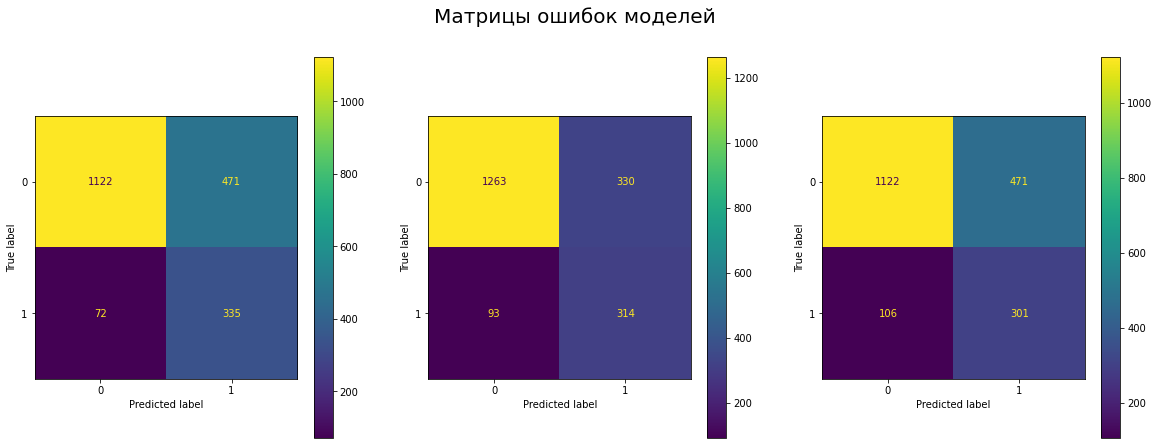

In [32]:
fig, ax = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Матрицы ошибок моделей', fontsize = 20)
ax[0]=ConfusionMatrixDisplay.from_estimator(best_model_DT_ds, features_valid, target_valid, ax = ax[0])
ax[1]=ConfusionMatrixDisplay.from_estimator(best_model_RF_ds, features_valid, target_valid, ax = ax[1])
ax[2]=ConfusionMatrixDisplay.from_estimator(best_model_LR_ds, features_valid_scaled, target_valid, ax = ax[2])
plt.show()

Во всех моделях смещение в сторону положительных ответов. 

Модель с весами дает большее улучшение меры F1 для Random Forest.

### OutSAmpling

Исследуем методы увеличения класса 1.

In [33]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(target_upsampled.value_counts())

1    4892
0    4777
Name: exited, dtype: int64


In [34]:
%%time
print('Decision Tree Classifier upsample')
best_model_DT_us = DT_model(features_upsampled, target_upsampled, None)
dict_DT_us = metrics('Decision Tree Classifier upsample',best_model_DT_us, features_valid, target_valid)
print('\n')

print('Random Forest Classifier upsample')
best_model_RF_us = RF_model(features_upsampled, target_upsampled, None)
dict_RF_us = metrics('Random Forest Classifier upsample',best_model_RF_us, features_valid, target_valid)
print('\n')


print('Logistic Regression Classifier upsample')
best_model_LR_us = LR_model(scaler(features_upsampled), target_upsampled, None)
dict_LR_us = metrics('Logistic Regression Classifier upsample', best_model_LR_us, scaler(features_valid), target_valid)


Decision Tree Classifier upsample
Параметры модели:
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12345,
 'splitter': 'best'}


,accuracy,recall,precision,f1_score,auc_roc
Decision Tree Classifier upsample,0.7655,0.702703,0.451104,0.549472,0.770243




Random Forest Classifier upsample
Параметры модели:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Random Forest Classifier upsample,0.8425,0.547912,0.629944,0.586071,0.84969




Logistic Regression Classifier upsample
Параметры модели:
{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 12345,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Logistic Regression Classifier upsample,0.7095,0.739558,0.387887,0.508876,0.79107


CPU times: total: 8min 1s
Wall time: 8min 9s


In [35]:
dict_scores_us = {**dict_DT_us,**dict_RF_us, **dict_LR_us}
table_scores_us = pd.DataFrame(dict_scores_us).T
table_scores_us.columns = ['accuracy', 'recall', 'precision', 'f1_score', 'auc_roc']
pd.concat([table_scores, table_scores_balanced, table_scores_ds, table_scores_us]).reset_index().sort_values(by = 'index').set_index('index')

,accuracy,recall,precision,f1_score,auc_roc
index,,,,,
Decision Tree Classifier,0.8560,0.511057,0.700337,0.590909,0.827298
Decision Tree Classifier balanced,0.7580,0.781327,0.446003,0.567857,0.821116
Decision Tree Classifier downsample,0.7285,0.823096,0.415633,0.552350,0.844566
Decision Tree Classifier upsample,0.7655,0.702703,0.451104,0.549472,0.770243
Logistic Regression Classifier,0.8195,0.213759,0.679688,0.325234,0.787667
Logistic Regression Classifier balanced,0.7170,0.724816,0.393858,0.510381,0.790893
Logistic Regression Classifier downsample,0.7115,0.739558,0.389896,0.510602,0.786242
Logistic Regression Classifier upsample,0.7095,0.739558,0.387887,0.508876,0.791070
Random Forest Classifier,0.8585,0.444717,0.760504,0.561240,0.858090


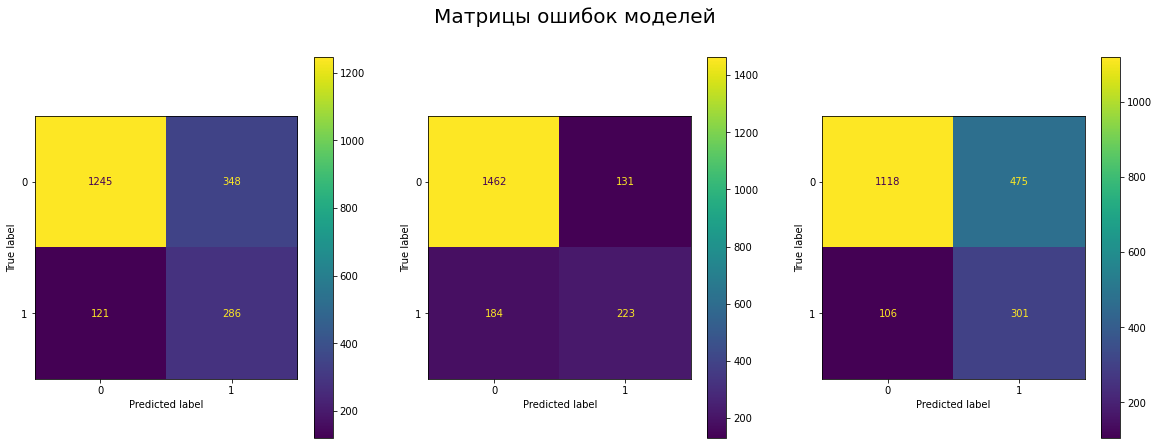

In [36]:
fig, ax = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Матрицы ошибок моделей', fontsize = 20)
ax[0]=ConfusionMatrixDisplay.from_estimator(best_model_DT_us, features_valid, target_valid, ax = ax[0])
ax[1]=ConfusionMatrixDisplay.from_estimator(best_model_RF_us, features_valid, target_valid, ax = ax[1])
ax[2]=ConfusionMatrixDisplay.from_estimator(best_model_LR_us, features_valid_scaled, target_valid, ax = ax[2])
plt.show()

Аналогично, предыдущим методам борьбы с несбалансироваными классами, имеем:

    - сильное увеличение F1-меры для LogisticRegression, но для метода с весами это увеличение больше;
    - увеличение F1-меры для Random Forest, но для метода с весами это увеличение больше;
    - уменьшение F1-меры для Decision Tree сильнее, чем в предыдущих методах.

Лучшие данные меры F1 для модели Random Forest.

Лучшая борьба с дисбалансом данных - взвешенные классы.

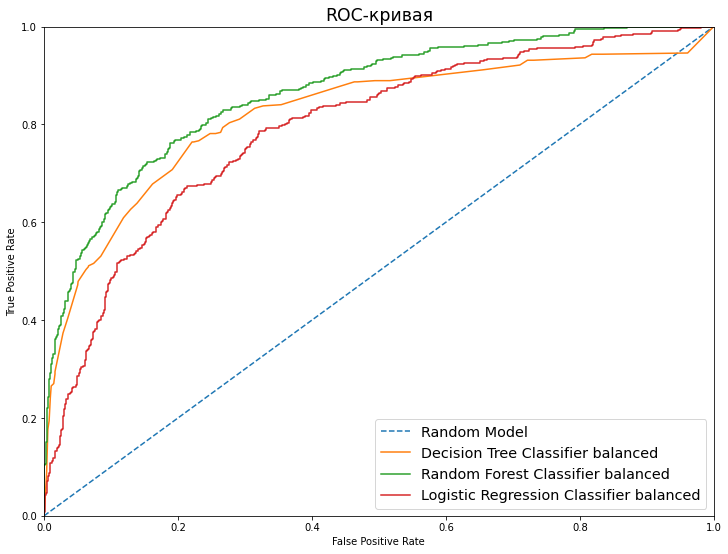

In [37]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

roc('Decision Tree Classifier balanced', best_model_DT_balanced, features_valid, target_valid)
roc('Random Forest Classifier balanced', best_model_RF_balanced, features_valid, target_valid)
roc('Logistic Regression Classifier balanced', best_model_LR_balanced, features_valid_scaled, target_valid)
    
    
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-кривая", fontsize = 'xx-large')
plt.show()

<a id = 'data_preparation'></a>
<div style = 'border: solid green 4px; padding: 20px'>
    
**Выводы**
    
По результатам исследования моделей с учётом дисбаланса классов наилучшим образом себя показала модель "Cлучайный лес". У этой модели наиболее высокий показатель F1- меры, а также высокий показатель AUC-ROC.
    
Взвешивание классов при обучении модели привело к лучший результатам нежели увеличение или уменьшении выборки.
    
ДЛя финального тестирования будем использовать модель Random Forest с параметром class_weight = 'balanced'.

## Финальное тестирование

In [38]:
features_train = features_train.append(features_valid) #increase the training set
target_train = target_train.append(target_valid)

Random Forest Classifier balanced
Параметры модели:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}


,accuracy,recall,precision,f1_score,auc_roc
Random Forest Classifier balanced,0.855,0.648649,0.642336,0.645477,0.867513


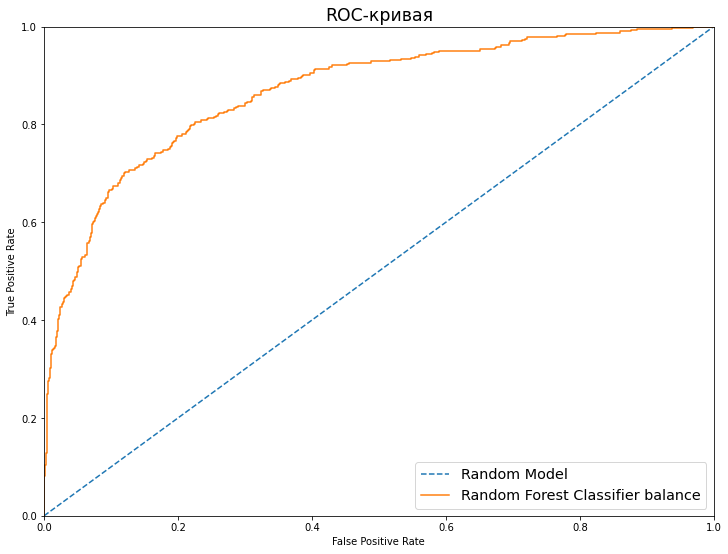

In [39]:
print('Random Forest Classifier balanced')
best_model_RF_balanced = RF_model(features_train, target_train, 'balanced')
metrics('Random Forest Classifier balanced', best_model_RF_balanced, features_test, target_test)

plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

roc('Random Forest Classifier balance', best_model_RF_balanced, features_test, target_test)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-кривая", fontsize = 'xx-large')
plt.show()

Сравним работу нашей модели с наивной, выдающей константный целовой признак = 0 (наиболее встречающийся).

In [40]:
model_dmb = DummyClassifier(strategy='most_frequent', random_state=12345, constant = 0)
model_dmb.fit(features_train, target_train)
print('Random model')
dict_dmb = metrics('Random Model', model_dmb, features_test, target_test)

Random model
Параметры модели:
{'constant': 0, 'random_state': 12345, 'strategy': 'most_frequent'}


,accuracy,recall,precision,f1_score,auc_roc
Random Model,0.7965,0.0,0.0,0.0,0.5


"Важность" признаков в модели Случайного Леса


,features,importance
1,age,0.296437
3,num_of_products,0.178120
2,balance,0.144910
6,estimated_salary,0.121983
0,credit_score,0.117656
5,is_active_member,0.052390
7,geography_Germany,0.036564
9,gender_Male,0.024291
4,has_cr_card,0.014316
8,geography_Spain,0.013334


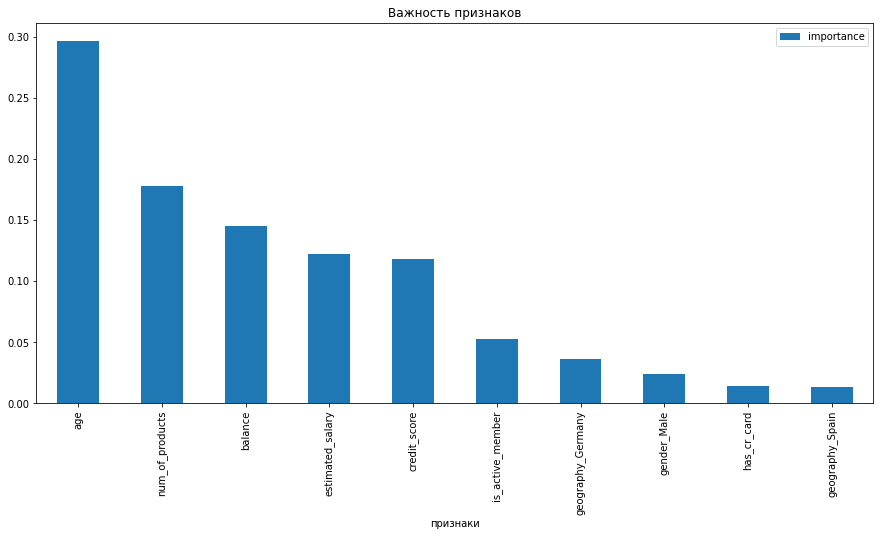

In [41]:
feats_RF = {feature:importance for feature, importance in zip(features.columns, best_model_RF_balanced.feature_importances_)}
importances_RF = pd.DataFrame(feats_RF.items(), columns = ['features', 'importance'])
print('"Важность" признаков в модели Случайного Леса')
importances_RF.sort_values(by='importance', ascending = False).plot(kind = 'bar', x = 'features', title = 'Важность признаков', xlabel = 'признаки', figsize = (15,7))
importances_RF.sort_values(by='importance', ascending = False)

Из барплота важностей признаков, видим что наши предположения после анализа данных вначале проекта подтвердились. Действительно, больше всего влияет на результат возраст клиента, затем (на втором месте) количество используемых продуктов банка.

<a id = 'data_preparation'></a>
<div style = 'border: solid green 6px; padding: 20px'>
    
**Вывод**

 - Были изучены данные. Выполнена предообработка, проведен разведочный анализ данных. 
 - Разбиты данные на тренировочную, валидационную и тестовую выборку.
 - Установлен факт несбалансируемых классов.
 - Проверены модели на данных без балансировки классов. 
 - Выполнен подбор гиперпараметров с полощью GridSearch.
 - В качестве контрольной метрики используем F1 меру.   
 - Для борьбы с дисбалансом были использованы 3 метода, лучше всего себя показал метод взвешенных классов на модели Случайного леса.
 - Проведен финальный тест.
    - используемая модель: Random Forest
    - параметры: {'bootstrap': True,
                  'ccp_alpha': 0.0,
                 'class_weight': 'balanced',
                 'criterion': 'gini',
                 'max_depth': None,
                 'max_features': 'auto',
                 'max_leaf_nodes': None,
                 'max_samples': None,
                 'min_impurity_decrease': 0.0,
                 'min_samples_leaf': 4,
                 'min_samples_split': 2,
                 'min_weight_fraction_leaf': 0.0,
                 'n_estimators': 100,
                 'n_jobs': None,
                 'oob_score': False,
                 'random_state': 12345,
                 'verbose': 0,
                 'warm_start': False}
    - полученные метрики:
        - accuracy = 0.855
        - recall = 0.648649
        - precision = 0.642336
        - ***f1_score = 0.645477***
        - aux_roc = 0.867513
    - проверили модели на вменяемость, сравнением с константной моделью.
    - рассмотрели важность признаков.
    
    

<div class="alert alert-info>
<h3> Итоговый комментарий</h3>

Большое спасибо за проделанную работу. Видно, что приложено много усилий. Выводы и рассуждения получились содержательными, их было интересно читать. Работа в целом и каждый шаг в отдельности сделаны хорошо. Я оставил несколько советов, надеюсь они будут учтены в будущих проектах. Проект может быть зачтен, но я его отправлю назад, чтобы у тебя была возможность задать вопросы и внести правки, при желании. Однако, ты можешь просто вернуть проект в таком же виде и я его зачту.
